In [1]:
import matplotlib.pyplot as plt
from skdh.sleep.sleep_classification import compute_sleep_predictions
from skdh.preprocessing import DETACH, CountWearDetection, CtaWearDetection, AccelThresholdWearDetection, CalibrateAccelerometer
import dill as pickle
import pandas as pd
import numpy as np


In [3]:
with open("../examples/pickle/galaxy_loader.pkl", "rb") as f:
    ukb_loader = pickle.load(f)

ukb_loader.sf_data.index.min()



Timestamp('2024-10-17 00:00:00')

In [5]:
# sf=0.005 for ukb
predictions = compute_sleep_predictions(ukb_loader.ml_data["ENMO"], sf=0.008)

In [6]:
data = pd.DataFrame({"Timestamp": ukb_loader.enmo_df.index, "Value": predictions})

# Separate data for plotting
blue_points = data[data["Value"] == 1]
green_points = data[data["Value"] == 0]


# Plot timeline
plt.figure(figsize=(10, 2))
plt.scatter(green_points["Timestamp"], [0] * len(green_points), color="green", label="0", marker="o")
plt.scatter(blue_points["Timestamp"], [0] * len(blue_points), color="blue", label="1", marker="o")


# Add labels and formatting
plt.yticks([-0.1, 0.1])
plt.xlabel("Time")
plt.title("Timeline with Markers")
plt.legend(loc="upper right")
plt.grid(axis="x", linestyle="--", alpha=0.5)

AttributeError: 'GalaxyDataLoader' object has no attribute 'enmo_df'

In [13]:
time = np.array(ukb_loader.sf_data.index.astype('int64') // 10**9)
acc = np.array(ukb_loader.sf_data[["X_raw", "Y_raw", "Z_raw"]]).astype(np.float64)/1000
temp = np.zeros(len(time))
print(acc.shape)
print(time.shape)
print(temp.shape)
print(type(acc))
print(type(time))
print(type(temp))

(10800000, 3)
(10800000,)
(10800000,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [16]:
wear_predictor = CountWearDetection()
wear = wear_predictor.predict(time=time, accel=acc, fs=25)
wear


{'wear': array([[       0,  5734500],
        [ 5940000,  8091000],
        [ 8257500, 10799999]])}

In [17]:
index = ukb_loader.sf_data.index
index

DatetimeIndex([       '2024-10-17 00:00:00', '2024-10-17 00:00:00.040000',
               '2024-10-17 00:00:00.080000', '2024-10-17 00:00:00.120000',
               '2024-10-17 00:00:00.160000', '2024-10-17 00:00:00.200000',
               '2024-10-17 00:00:00.240000', '2024-10-17 00:00:00.280000',
               '2024-10-17 00:00:00.320000', '2024-10-17 00:00:00.360000',
               ...
               '2024-10-21 23:59:59.600000', '2024-10-21 23:59:59.640000',
               '2024-10-21 23:59:59.680000', '2024-10-21 23:59:59.720000',
               '2024-10-21 23:59:59.760000', '2024-10-21 23:59:59.800000',
               '2024-10-21 23:59:59.840000', '2024-10-21 23:59:59.880000',
               '2024-10-21 23:59:59.920000', '2024-10-21 23:59:59.960000'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=10800000, freq='40ms')

In [18]:
len = len(index)
array = np.zeros(len)
for start, end in wear['wear']:
    array[start:end+1] = 1

In [27]:
array = pd.DataFrame(array, columns=['wear']).set_index(index)
array

,wear
TIMESTAMP,
2024-10-17 00:00:00.000,1.0
2024-10-17 00:00:00.040,1.0
2024-10-17 00:00:00.080,1.0
2024-10-17 00:00:00.120,1.0
2024-10-17 00:00:00.160,1.0
...,...
2024-10-21 23:59:59.800,1.0
2024-10-21 23:59:59.840,1.0
2024-10-21 23:59:59.880,1.0


In [14]:
calibrator = CalibrateAccelerometer(sphere_crit=1, sd_criteria=0.3)
calibrated = calibrator.predict(time=time, accel=acc, fs=25)
calibrated


/Users/jacobleooskar/Documents/Education/ETHZ/Curriculum/Semester03/03SemProj/CosinorAge/venv/lib/python3.9/site-packages/skdh/preprocessing/calibrate.py:192: UserWarning: Recalibration not done with 108 - 120 hours due to insufficient non-movement data available
  warn(


{'accel': array([[-1.919, -2.549, -2.661],
        [-1.919, -2.549, -2.661],
        [-1.919, -2.549, -2.661],
        ...,
        [ 0.829,  0.104,  4.081],
        [ 0.829,  0.104,  4.081],
        [ 0.829,  0.104,  4.081]]),
 'offset': array([-0.39468431,  0.15851819, -0.03519462]),
 'scale': array([0.43352811, 0.5125329 , 0.42696396]),
 'temperature scale': array([[0., 0., 0.]])}

In [15]:
# convert this nd-array into a pandas dataframe with columns 'X', 'Y', 'Z'

calibrated = pd.DataFrame(calibrated['accel'], columns=['X', 'Y', 'Z'])
calibrated.set_index(ukb_loader.sf_data.index, inplace=True)
calibrated

,X,Y,Z
TIMESTAMP,,,
2024-10-17 00:00:00.000,-1.919,-2.549,-2.661
2024-10-17 00:00:00.040,-1.919,-2.549,-2.661
2024-10-17 00:00:00.080,-1.919,-2.549,-2.661
2024-10-17 00:00:00.120,-1.919,-2.549,-2.661
2024-10-17 00:00:00.160,-1.919,-2.549,-2.661
...,...,...,...
2024-10-21 23:59:59.800,0.829,0.104,4.081
2024-10-21 23:59:59.840,0.829,0.104,4.081
2024-10-21 23:59:59.880,0.829,0.104,4.081


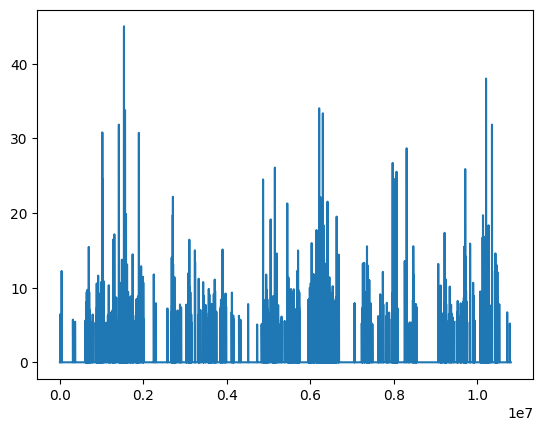

In [8]:
# calculate enmo
x = calibrated['accel'][:, 0]
y = calibrated['accel'][:, 1]
z = calibrated['accel'][:, 2]
enmo = np.sqrt(x**2 + y**2 + z**2)-1
# set values below 0 to 0
enmo = np.where(enmo < 5, 0, enmo)

plt.plot(enmo)


(array([1.0694814e+07, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.6965000e+04,
        1.7210000e+04, 1.1325000e+04, 8.0490000e+03, 5.2200000e+03,
        4.0450000e+03, 3.2310000e+03, 2.9810000e+03, 2.4630000e+03,
        2.1070000e+03, 1.9670000e+03, 1.6890000e+03, 1.5870000e+03,
        1.4020000e+03, 1.3510000e+03, 1.2990000e+03, 1.1710000e+03,
        1.0860000e+03, 1.3680000e+03, 1.2400000e+03, 1.1700000e+03,
        8.5200000e+02, 7.2600000e+02, 6.7300000e+02, 6.1800000e+02,
        5.7700000e+02, 4.8000000e+02, 3.9600000e+02, 2.9100000e+02,
        2.5800000e+02, 2.6900000e+02, 1.9300000e+02, 1.0100000e+02,
        1.0300000e+02, 9.8000000e+01, 9.1000000e+01, 8.2000000e+01,
        7.3000000e+01, 7.1000000e+01, 5.9000000e+01, 3.8000000e+01,
        3.1000000e+01, 3.0000000e+01, 2.5000000e+01, 1.7000000e+01,
        1.0000000e+01, 1.0000000e+01, 5.0000000e

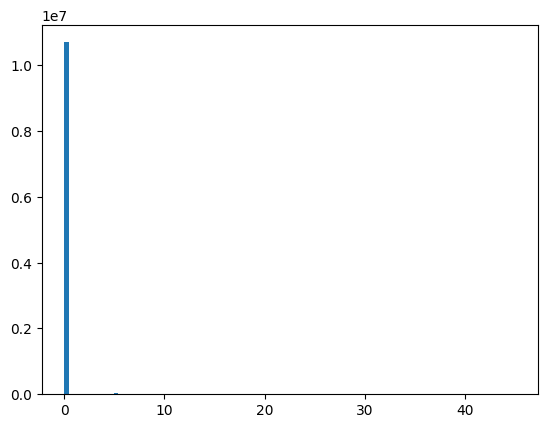

In [9]:
plt.hist(enmo, bins=100)